# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [2]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n):  y


Running on cuda:0


In [5]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.505
adam: Epoch 4 Loss 0.304
adam: Epoch 6 Loss 0.251
adam: Epoch 8 Loss 0.232
adam: Epoch 10 Loss 0.205
adam: Epoch 12 Loss 0.197
adam: Epoch 14 Loss 0.185
adam: Epoch 16 Loss 0.177
adam: Epoch 18 Loss 0.175
adam: Epoch 20 Loss 0.167


Text(0.5, 1.0, 'MNIST')

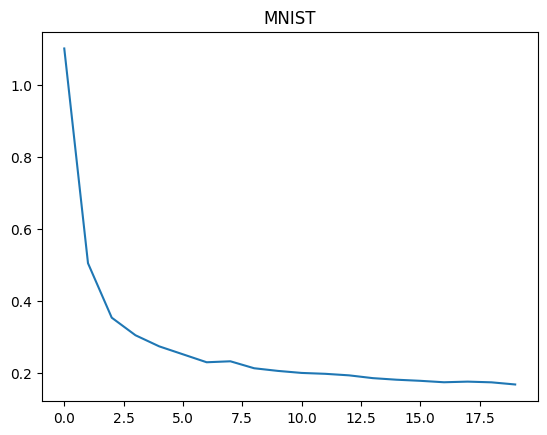

In [6]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
error_t = torch.tensor(cnnet.error_trace, device = "cpu")
plt.plot(error_t, label='Pytorch')
plt.title('MNIST')

In [7]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [8]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.58


,0,1,2,3,4,5,6,7,8,9
0,96.734694,0.000000,0.204082,0.102041,0.408163,0.612245,0.612245,0.102041,0.918367,0.306122
1,0.088106,97.180617,0.969163,0.528634,0.000000,0.000000,0.176211,0.088106,0.969163,0.000000
2,0.968992,0.872093,94.864341,0.484496,0.581395,0.000000,0.193798,1.453488,0.484496,0.096899
3,0.000000,0.693069,0.891089,95.247525,0.000000,0.990099,0.000000,0.693069,0.693069,0.792079
4,1.018330,0.000000,0.203666,0.000000,95.010183,0.203666,1.018330,0.305499,0.000000,2.240326
5,0.448430,0.000000,0.000000,2.914798,0.000000,91.704036,1.569507,0.672646,2.130045,0.560538
6,1.461378,0.104384,0.835073,0.104384,0.313152,0.417537,96.033403,0.000000,0.730689,0.000000
7,0.000000,0.389105,1.945525,0.972763,0.194553,0.000000,0.194553,95.038911,0.389105,0.875486
8,2.053388,1.334702,0.513347,0.616016,0.410678,0.616016,0.718686,0.924025,91.067762,1.745380
9,0.396432,0.396432,0.000000,1.684836,1.486620,0.693756,0.099108,1.288404,1.684836,92.269574


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [9]:
import time

n_inputs = Xtrain.shape[-1]**2
n_outputs = len(np.unique(Ttrain))
architectures = [ 
                 [[10], [5], [5], [1]],            
                 [[10, 10], [5], [5, 5], [1, 1]],
                 [[10, 10, 10], [5], [5, 5, 5], [1, 1, 1]]
                ]
             
n_epochs = 20
batch_size = 500
learning_rate = 0.01

best_arch = [0.0, 0.0, 0.0, 0.0]
arch_stats_list = []

for arch in architectures:
    start = time.time()
    cnn2d = CNN2D(n_inputs, arch[0], arch[1], n_outputs, arch[2], arch[3], device=device)
    cnn2d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
        
    Ytrain_c,_ = cnn2d.use(Xtrain)
    train_perc =  100 * np.mean(Ttrain == Ytrain_c)
    Ytest_c,_ = cnn2d.use(Xtest)
    test_perc =  100 * np.mean(Ttest == Ytest_c)
    elapsed_time = (time.time() - start) / 60
    arch_stats = [arch, test_perc, train_perc, elapsed_time]
    arch_stats_list.append(arch_stats)
    
    print(f'Took {elapsed_time:.2f} minutes for the architecture {arch}') 
    if test_perc > best_arch[1]:
        best_arch = arch
    
    del Ytrain_c, Ytest_c, cnn2d, test_perc, train_perc, arch_stats, _
    torch.cuda.empty_cache()
    
print(f'The best architecture is {best_arch}')

adam: Epoch 2 Loss 0.777
adam: Epoch 4 Loss 0.628
adam: Epoch 6 Loss 0.583
adam: Epoch 8 Loss 0.556
adam: Epoch 10 Loss 0.522
adam: Epoch 12 Loss 0.505
adam: Epoch 14 Loss 0.487
adam: Epoch 16 Loss 0.474
adam: Epoch 18 Loss 0.443
adam: Epoch 20 Loss 0.453
Took 0.08 minutes for the architecture [[10], [5], [5], [1]]
adam: Epoch 2 Loss 0.704
adam: Epoch 4 Loss 0.496
adam: Epoch 6 Loss 0.406
adam: Epoch 8 Loss 0.353
adam: Epoch 10 Loss 0.345
adam: Epoch 12 Loss 0.300
adam: Epoch 14 Loss 0.313
adam: Epoch 16 Loss 0.289
adam: Epoch 18 Loss 0.289
adam: Epoch 20 Loss 0.293
Took 0.20 minutes for the architecture [[10, 10], [5], [5, 5], [1, 1]]
adam: Epoch 2 Loss 0.529
adam: Epoch 4 Loss 0.366
adam: Epoch 6 Loss 0.329
adam: Epoch 8 Loss 0.317
adam: Epoch 10 Loss 0.298
adam: Epoch 12 Loss 0.282
adam: Epoch 14 Loss 0.275
adam: Epoch 16 Loss 0.265
adam: Epoch 18 Loss 0.274
adam: Epoch 20 Loss 0.251
Took 0.29 minutes for the architecture [[10, 10, 10], [5], [5, 5, 5], [1, 1, 1]]
The best architectu

In [10]:
fc_layer_options = [ [], [10], [10, 10] ]

best_fc = [0.0, 0.0, 0.0, 0.0]

for fc in fc_layer_options:
    start = time.time()
    cnn2d = CNN2D(n_inputs, best_arch[0], fc, n_outputs, best_arch[2], best_arch[3], device=device)
    cnn2d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
        
    Ytrain_c,_ = cnn2d.use(Xtrain)
    train_perc =  100 * np.mean(Ttrain == Ytrain_c)
    Ytest_c,_ = cnn2d.use(Xtest)
    test_perc =  100 * np.mean(Ttest == Ytest_c)
    elapsed_time = (time.time() - start) / 60
    fc_stats = [[best_arch[0], fc, best_arch[2], best_arch[3]], test_perc, train_perc, elapsed_time]
    arch_stats_list.append(fc_stats)

    print(f'Took {elapsed_time:.2f} minutes for the network {fc_stats[0]}')
    if test_perc > best_fc[1]:
        best_fc = fc_stats
    
    del Ytrain_c, Ytest_c, cnn2d, test_perc, train_perc, fc_stats, _
    torch.cuda.empty_cache()
    
print(f'The best fc layer is {best_fc[0][1]}')

adam: Epoch 2 Loss 0.173
adam: Epoch 4 Loss 0.168
adam: Epoch 6 Loss 0.153
adam: Epoch 8 Loss 0.109
adam: Epoch 10 Loss 0.147
adam: Epoch 12 Loss 0.101
adam: Epoch 14 Loss 0.102
adam: Epoch 16 Loss 0.089
adam: Epoch 18 Loss 0.100
adam: Epoch 20 Loss 0.089
Took 0.29 minutes for the network [[10, 10, 10], [], [5, 5, 5], [1, 1, 1]]
adam: Epoch 2 Loss 0.307
adam: Epoch 4 Loss 0.210
adam: Epoch 6 Loss 0.196
adam: Epoch 8 Loss 0.189
adam: Epoch 10 Loss 0.179
adam: Epoch 12 Loss 0.158
adam: Epoch 14 Loss 0.175
adam: Epoch 16 Loss 0.177
adam: Epoch 18 Loss 0.159
adam: Epoch 20 Loss 0.148
Took 0.29 minutes for the network [[10, 10, 10], [10], [5, 5, 5], [1, 1, 1]]
adam: Epoch 2 Loss 0.402
adam: Epoch 4 Loss 0.287
adam: Epoch 6 Loss 0.275
adam: Epoch 8 Loss 0.241
adam: Epoch 10 Loss 0.218
adam: Epoch 12 Loss 0.208
adam: Epoch 14 Loss 0.225
adam: Epoch 16 Loss 0.204
adam: Epoch 18 Loss 0.206
adam: Epoch 20 Loss 0.221
Took 0.29 minutes for the network [[10, 10, 10], [10, 10], [5, 5, 5], [1, 1, 1]]

In [11]:
cnn2d_df = pandas.DataFrame(arch_stats_list)
cnn2d_df.columns = ['Network', 'Test', 'Train', 'Time in Min.']
cnn2d_df

,Network,Test,Train,Time in Min.
0,"[[10], [5], [5], [1]]",90.02,90.070,0.084839
1,"[[10, 10], [5], [5, 5], [1, 1]]",92.97,93.204,0.202991
2,"[[10, 10, 10], [5], [5, 5, 5], [1, 1, 1]]",94.70,94.624,0.285488
3,"[[10, 10, 10], [], [5, 5, 5], [1, 1, 1]]",97.90,98.946,0.287023
4,"[[10, 10, 10], [10], [5, 5, 5], [1, 1, 1]]",95.50,95.536,0.289462
5,"[[10, 10, 10], [10, 10], [5, 5, 5], [1, 1, 1]]",93.51,93.084,0.292920


### Discussion CNN2D on MNIST Dataset

As a note, the test runs took up more GPU memory than expected. My first few runs wouldn't fully execute due to the maxing out of my GPU memory. This is why I delete all my prediction information and models at the end of each iteration. 

When looking at the first three model performances, which differ in number of convolution layers, the best performance is the architecture consisting of [[10, 10, 10], [5], [5, 5, 5], [1, 1, 1]]. This shows that the model can better predict the image with a higher convolutional depth. Though, we do not see any drastic differences in performance, showing that the number of convolution layers may not be a larger impact to model performance when training on a subset of the MNIST dataset. So, we may want to settle for a less complex network of convolution layers if we see a jump in performance through testing other network parameters. The increase in training time, from the increased compelxity of these layers, may not be worth it if we can make up for the ~2% increase of accuracy other network parameters. Further experiments concerning fully connected layers, patch size, and strides would be necessary to know for sure.

With the last three models, where we try a different number of fully connected layers, we see a larger seperation in the performance accuracy of the models. To my suprise, the usage of no fully connected layers seems to provide the best model performance when training on a subset of the MNIST data. Outpacing the model utilizing one fully connected of 10 units by nearly 2%. I would guess that this improvement is due to fully connected layers have a tendency to remove data from images as a way to counteract noise. Since the MNIST dataset is not consistent of complex layers of imagery, the fully connected layers may be removing information that the model can use to tell the difference between the 10 classes. 

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [12]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):

        n_in = 1
        input_hw = int(n_inputs)  
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, 
                                                    kernel_size=patch_size, 
                                                    stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size 
                        {patch_size}. Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [13]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [14]:
square_pulse = make_square_pulse()
square_pulse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

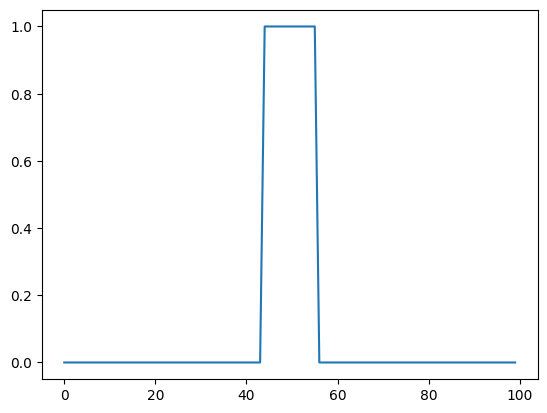

In [15]:
plt.plot(square_pulse)

In [16]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [17]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.5 , 0.75, 1.  , 1.  , 0.75, 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.5 , 1.  , 1.  , 0.5 , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

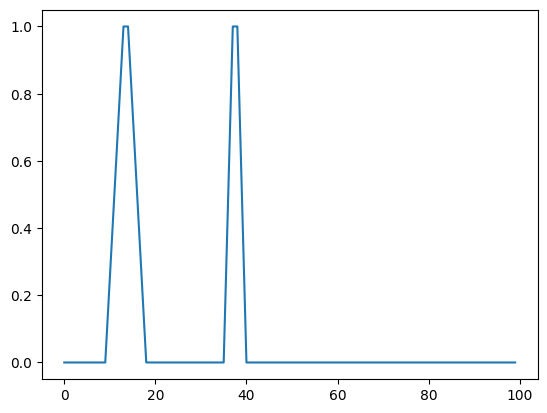

In [18]:
plt.plot(triangular_pulse)

In [19]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [20]:
np.newaxis == None

True

In [21]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [22]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.595
adam: Epoch 20 Loss 0.350
adam: Epoch 30 Loss 0.070
adam: Epoch 40 Loss 0.012
adam: Epoch 50 Loss 0.004
adam: Epoch 60 Loss 0.001
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.000
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

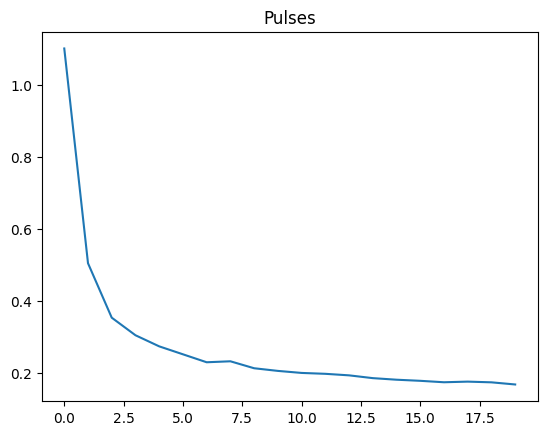

In [23]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
error_t = torch.tensor(cnnet.error_trace, device = "cpu")
plt.plot(error_t, label='Pytorch')
plt.title('Pulses')

In [24]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.10


,square,triangular
square,98.4,1.6
triangular,0.2,99.8


torch.Size([10, 10])

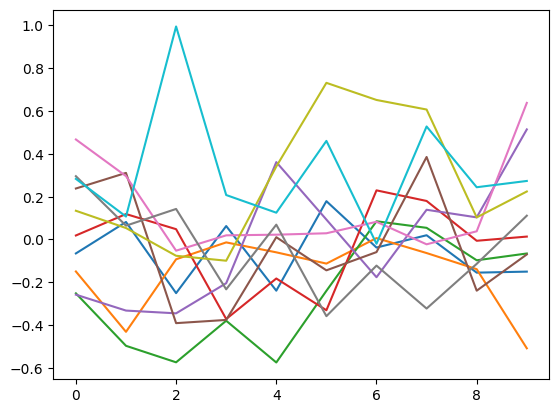

In [25]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [26]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

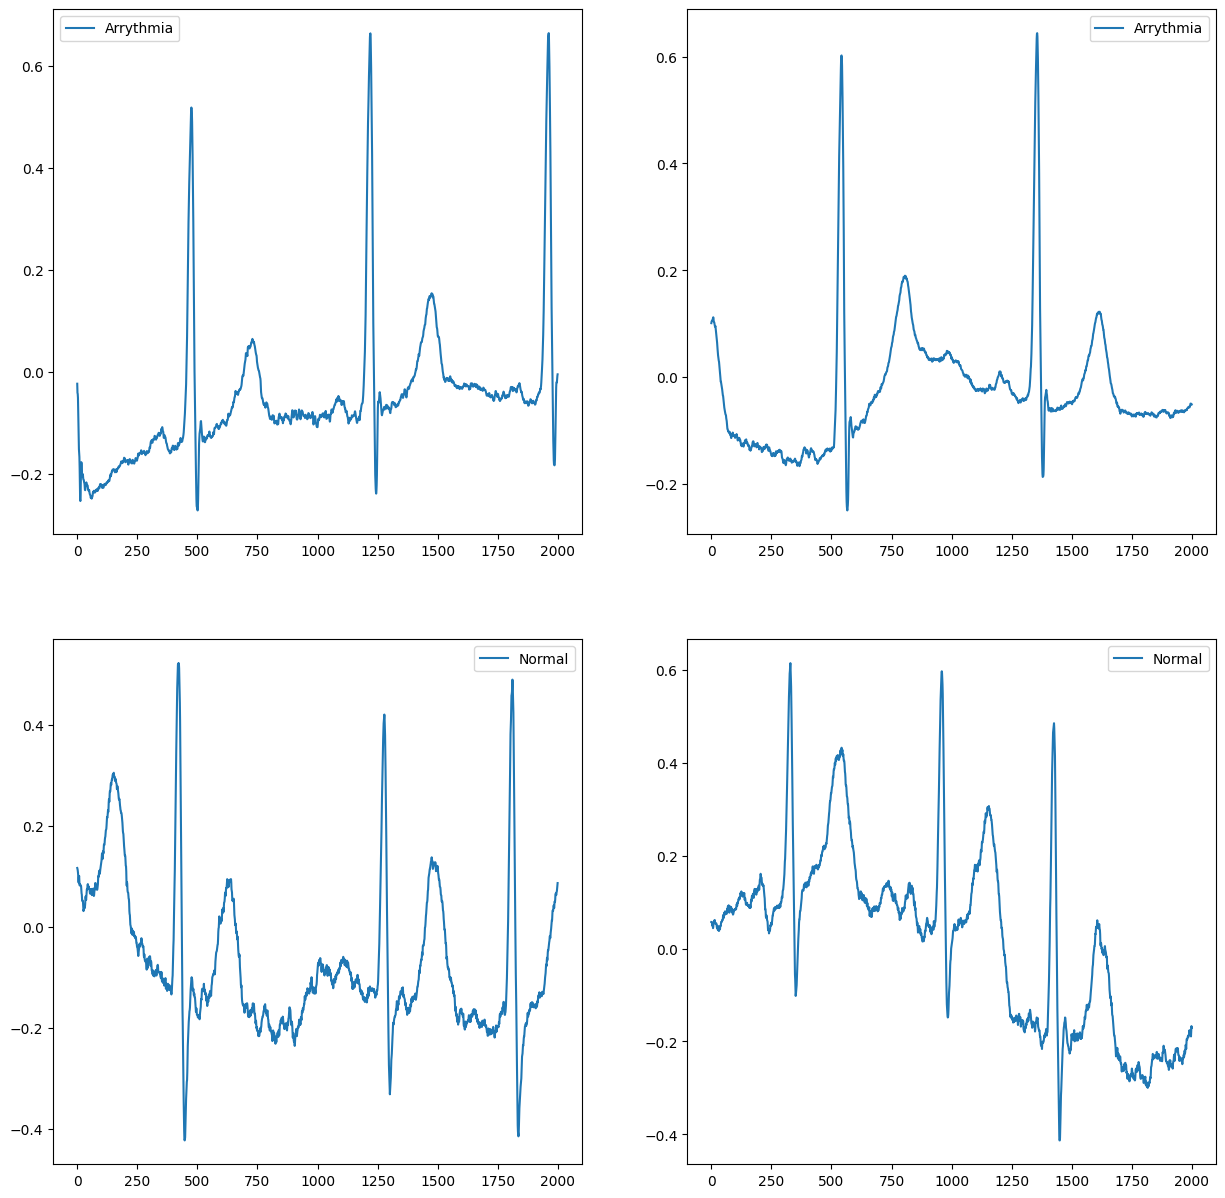

In [27]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [28]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [29]:
Ttrain

array([['nr'],
       ['arr'],
       ['nr'],
       ...,
       ['nr'],
       ['arr'],
       ['arr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [30]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)
# n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, patch_size, stride,  device

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [31]:
n_inputs = Xtrain.shape[-1]
n_outputs = 2
networks = [ [[5, 10], [10, 10], [50, 10], [1, 1]],                #1
             [[5, 10], [10, 10], [50, 10], [20, 5]],
             [[5, 10], [10, 10], [100, 20], [20, 5]],              #3
             [[5, 10], [20, 20], [100, 20], [20, 5]],
             [[10, 20], [20, 20], [200, 40], [40, 10]],            #5
             [[10, 20], [40, 40], [200, 40], [40, 10]],
             [[10, 20], [40, 40], [200, 40], [1, 1]],            #7
             [[10, 20], [40], [200, 40], [1, 1]],
             [[5, 10, 20], [10], [3, 3, 3], [1, 1, 1]],    #9
             [[5, 10, 20], [ 10, 10], [3, 3, 3], [1, 1, 1]],       
             [[5, 10, 20], [10, 20], [5, 5, 5], [1, 1, 1]],      #11
           ]
             
n_epochs =  100
batch_size = 10
learning_rate = 0.001

best_net = [0, 0, 0, 0]
network_stats_list = []

for network in networks:
    start = time.time()
    cnn1d = CNN1D(n_inputs, network[0], network[1], n_outputs, network[2], network[3], device=device)
    cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
        
    Ytrain_c,_ = cnn1d.use(Xtrain)
    train_perc =  100 * np.mean(Ttrain == Ytrain_c)
    Ytest_c,_ = cnn1d.use(Xtest)
    test_perc =  100 * np.mean(Ttrain == Ytrain_c)
    elapsed_time = (time.time() - start) / 60
    network_stats = [network, test_perc, train_perc, elapsed_time]
    network_stats_list.append(network_stats)
    
    if test_perc > best_net[1]:
        best_net = network_stats
        
    print(f'Took {elapsed_time:.2f} minutes for the network {network}') 
    del Ytrain_c, Ytest_c, cnn1d, test_perc, train_perc, network_stats,_
    torch.cuda.empty_cache()
    
print(f'The best network is {best_net[0]}')

adam: Epoch 10 Loss 0.652
adam: Epoch 20 Loss 0.663
adam: Epoch 30 Loss 0.659
adam: Epoch 40 Loss 0.647
adam: Epoch 50 Loss 0.649
adam: Epoch 60 Loss 0.639
adam: Epoch 70 Loss 0.652
adam: Epoch 80 Loss 0.667
adam: Epoch 90 Loss 0.663
adam: Epoch 100 Loss 0.657
Took 1.41 minutes for the network [[5, 10], [10, 10], [50, 10], [1, 1]]
adam: Epoch 10 Loss 0.520
adam: Epoch 20 Loss 0.319
adam: Epoch 30 Loss 0.231
adam: Epoch 40 Loss 0.181
adam: Epoch 50 Loss 0.143
adam: Epoch 60 Loss 0.111
adam: Epoch 70 Loss 0.112
adam: Epoch 80 Loss 0.087
adam: Epoch 90 Loss 0.090
adam: Epoch 100 Loss 0.063
Took 1.23 minutes for the network [[5, 10], [10, 10], [50, 10], [20, 5]]
adam: Epoch 10 Loss 0.371
adam: Epoch 20 Loss 0.230
adam: Epoch 30 Loss 0.133
adam: Epoch 40 Loss 0.080
adam: Epoch 50 Loss 0.093
adam: Epoch 60 Loss 0.066
adam: Epoch 70 Loss 0.030
adam: Epoch 80 Loss 0.020
adam: Epoch 90 Loss 0.027
adam: Epoch 100 Loss 0.049
Took 1.25 minutes for the network [[5, 10], [10, 10], [100, 20], [20, 5]

In [32]:
cnn1d_df = pandas.DataFrame(network_stats_list)
cnn1d_df.columns = ['Network', 'Test Acc. (%)', 'Train Acc. (%)','Time in Min.']
cnn1d_df

,Network,Test Acc. (%),Train Acc. (%),Time in Min.
0,"[[5, 10], [10, 10], [50, 10], [1, 1]]",60.721649,60.721649,1.409371
1,"[[5, 10], [10, 10], [50, 10], [20, 5]]",95.546392,95.546392,1.234543
2,"[[5, 10], [10, 10], [100, 20], [20, 5]]",96.494845,96.494845,1.250730
3,"[[5, 10], [20, 20], [100, 20], [20, 5]]",100.000000,100.000000,1.363369
4,"[[10, 20], [20, 20], [200, 40], [40, 10]]",99.072165,99.072165,1.226101
5,"[[10, 20], [40, 40], [200, 40], [40, 10]]",98.536082,98.536082,1.263717
6,"[[10, 20], [40, 40], [200, 40], [1, 1]]",70.927835,70.927835,2.163837
7,"[[10, 20], [40], [200, 40], [1, 1]]",80.556701,80.556701,2.004559
8,"[[5, 10, 20], [10], [3, 3, 3], [1, 1, 1]]",60.721649,60.721649,2.110449
9,"[[5, 10, 20], [10, 10], [3, 3, 3], [1, 1, 1]]",60.721649,60.721649,2.394195


### Discussion ECG Dataset with CNN1D

The best function network seems to be [[5, 10], [20, 20], [100, 20], [20, 5]], as it was the only one able to achieve 100% accuracy. Other networks that were close, but unable to achieive a perfect prediction on the test set were [[10, 20], [20, 20], [200, 40], [40, 10]], with an accuracy of 99.07%, and [[10, 20], [40, 40], [200, 40], [40, 10]], with an accuracy of 98.74. Given more epochs, I suspect that these three networks would produce an error of 0.

For the network composition, [[5, 10], [20, 20], [100, 20], [20, 5]], we see the model achieve 100% accuracy at 90 epochs, yet other network builds fail to reach this level of accuracy.  When comparing it to the architecture, [[5, 10], [10, 10], [100, 20], [20, 5]], we can tell that, again, the fully connected layers have a larger impact on the improvement of the model performance. Here, the model seems to benefit from doubling the units in the fully connected layers. What is different with the CNN1D with the ECG data, when compared to the CNN2D using the MNIST dataset, is that the model seems to benefit from a more complex fully connected layer structure. Seeing this fluxuation of model performance through different fully collected layer values, across both experiments, I can draw the conclusion that fully connected layers are one of the more sensitive network parameters and can greatly vary depending on data complexity.

Then, when we compare our best performing network to [[10, 20], [20, 20], [200, 40], [40, 10]], we see the accuracy drop by almost 1%. Though it is unclear if this drop is due to the increase in convolution layers, patch size, or stride by just looking it this expirement. When we look at the following network, [[10, 20], [40, 40], [200, 40], [1, 1]], the accuracy drops dramatically, by nearly 17%. This massive drop in accuracy is purely due to changing the number of stride steps, showing that downsampling allows the model to see certain patterns that it cannot see through taking single steps. When looking at [[10, 20], [40], [200, 40], [1, 1]], which reduces the fully connected layers by one, we see the accuracy jump up by nearly 10%. I think this happens because with smaller strides, the model picks up on less complex patterns, which requires a less complex feature mapping from the fully connected layers.

The last three experiments utilize a three layered convolution architecture. All three of them exhibet the same accuracy of 60.72%. This could be showing that a network of three layers is too complex for ECG dataset because as we change the number and values of the fully conected layers, and the patch sizes, the accuracy does not change. Alternatively, this issue could be due to the use of 1-valued strides, causing the model to not pick up on the more complex patterns across features.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [33]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Youngren-A5.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Youngren-A5.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.use(Xtrain)[0] == Ttrain)
    perc_test = 100 * np.mean(cnn1d.use(Xtest)[0] == Ttest)

adam: Epoch 2 Loss 0.013
adam: Epoch 4 Loss 0.004
adam: Epoch 6 Loss 0

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.